In [1]:
import os 
os.chdir("../../")

In [2]:
import glob
import numpy as np
from cids.util import metrics
from cids.util import misc_funcs as misc
import matplotlib.pyplot as plt

In [3]:
def get_threshold_iqr(run):
    scores = np.load(os.path.join(run, "train_scores.npy"))
    labels = np.load(os.path.join(run, "train_labels.npy"))

    benign_scores = scores[labels == 0]
    q1 = np.quantile(benign_scores, 0.25)
    q3 = np.quantile(benign_scores, 0.75)
    iqr = q3 - q1
    threshold = (q3 + 1.5 * iqr)
    return threshold, (scores, labels)

In [4]:
loss_types = ["baseline", "reciprocal"]
hosts = [201, 402, 811]  # List of hosts
gammas = [1.5, 1.25, 2.0]
lrs = [1.085e-06, 2.17e-06, 1.085e-06]
modes = ["test", "test_extern"]

all_runs = {}  # Dictionary to store run data for each host

for host, gamma, lr in zip(hosts, gammas, lrs):
    run = {loss_type: {k: {"scores": [], "labels": [], "mccs": [], "f1s": [], "precisions": [], "recalls": []} for k in modes} for loss_type in loss_types}
    for loss_type in loss_types:
        if loss_type == "reciprocal":
            result_dir = os.path.join(misc.root(), f"results/03_semisupervision/finetuned/MLPAE-{host}/SSL-FULL-ITER-{host}-{1 if host != 201 else 2}")
            runs = glob.glob(os.path.join(result_dir, f"{loss_type}--gamma{gamma}--lr{lr}/*"))
        elif loss_type == "baseline":
            result_dir = os.path.join(misc.root(), f"results/03_semisupervision/unsupervised/OpTC/MLPAE-{host}/BASE-{host}-1")
            runs = glob.glob(os.path.join(result_dir, "*"))
        print(len(runs))
        for seed in runs:
            t, (score_train, label_train) = get_threshold_iqr(seed)
            for mode in modes:
                test_scores = os.path.join(seed, f"{mode}_scores.npy")
                test_labels = os.path.join(seed, f"{mode}_labels.npy")

                score = np.load(test_scores)
                label = np.load(test_labels)
                tp = np.sum(score[label == 1] > t)
                fp = np.sum(score[label == 0] > t)
                fn = np.sum(score[label == 1] < t)
                tn = np.sum(score[label == 0] < t)

                mcc = metrics.mcc(label, (score > t).astype(int))
                f1 = metrics.f1_score(tp, fp, fn)
                precision = metrics.precision(tp, fp)
                recall = metrics.recall(tp, fn)

                run[loss_type][mode]["scores"].append(score)
                run[loss_type][mode]["labels"].append(label)
                run[loss_type][mode]["mccs"].append(mcc)
                run[loss_type][mode]["f1s"].append(f1)
                run[loss_type][mode]["precisions"].append(precision)
                run[loss_type][mode]["recalls"].append(recall)

    all_runs[host] = run  # Save run data for the current host


10
10
10
10
10
10


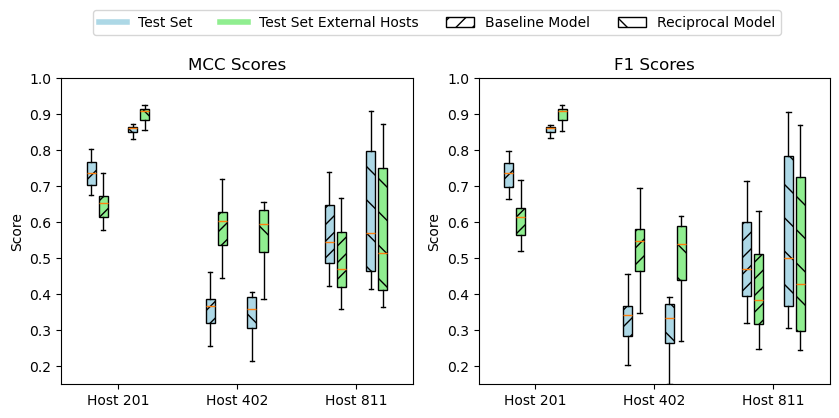

In [20]:
# Only plot MCC and F1 (no Precision, no Recall)
from matplotlib.patches import Patch
plt.rcParamsDefault.update({'font.size': 16})

host_offset = 2
mode_colors = {'test': 'lightblue', 'test_extern': 'lightgreen'}
fig, axs = plt.subplots(1, 2, figsize=(8.5, 4))  # 1 row, 2 columns

loss_type_offsets = {'baseline': -0.35, 'reciprocal': 0.35}
mode_offsets = {'test': -0.1, 'test_extern': 0.1}

metrics_list = ['MCC', 'F1']

# Optionally, set custom y-limits for each metric if desired
metric_ylims = {
    'MCC': (0.15, 1.0),
    'F1': (0.15, 1.0),
}

for ax, metric in zip(axs.flat, metrics_list):
    xticks = []
    xtick_labels = []
    for i, host in enumerate(hosts):
        base = i * host_offset
        # Plot each loss type and mode without outliers.
        for loss_type in loss_types:
            for mode in modes:
                if metric == 'MCC':
                    data_list = all_runs[host][loss_type][mode]["mccs"]
                elif metric == 'F1':
                    data_list = all_runs[host][loss_type][mode]["f1s"]
                pos = base + loss_type_offsets[loss_type] + mode_offsets[mode]
                bp = ax.boxplot(
                    data_list,
                    positions=[pos],
                    widths=0.15,
                    patch_artist=True,
                    showfliers=False
                )
                # Set a hatch pattern to distinguish loss types.
                hatch = '//' if loss_type == 'baseline' else '\\'
                for patch in bp['boxes']:
                    patch.set_facecolor(mode_colors[mode])
                    patch.set_edgecolor('black')
                    patch.set_hatch(hatch)
        xticks.append(base)
        xtick_labels.append(f"Host {host}")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_title(f"{metric} Scores")
    ax.set_ylabel("Score")
    # Set individual y-limits for each metric
    if metric in metric_ylims:
        ax.set_ylim(*metric_ylims[metric])

# Create handles for modes and loss types.
mode_handles = [plt.Line2D([0], [0], color=mode_colors[m], lw=4) for m in modes]
loss_type_handles = [
    Patch(facecolor='white', edgecolor='black', hatch='//' if lt=='baseline' else '\\', label=lt)
    for lt in loss_types
]

# Combine the handles and labels.
combined_handles = mode_handles + loss_type_handles
combined_labels = ["Test Set", "Test Set External Hosts", "Baseline Model", "Reciprocal Model"]

# Update the legend position now that we removed suptitle.
fig.legend(
    combined_handles,
    combined_labels,
    loc='upper center',
    bbox_to_anchor=(0.52, 1.05),
    ncol=len(combined_handles)
)

# Adjust layout so there's room for the legend.
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("plots/compare_overfit_ssl_mcc_f1.pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

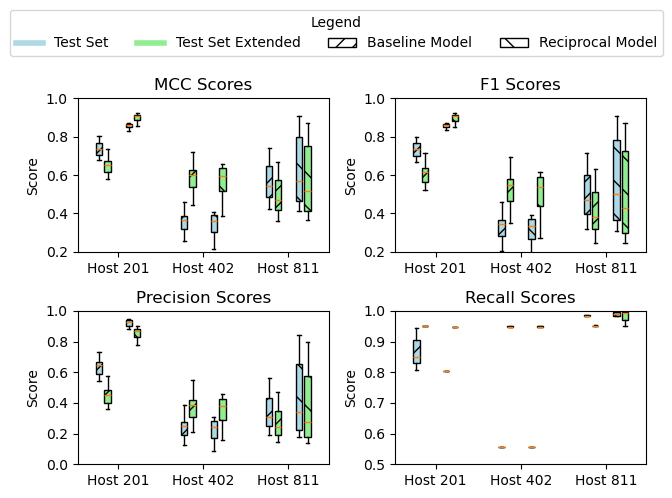

In [6]:
# Expand boxplot to 2x2 grid: MCC, F1, Precision, Recall, each with its own y-axis
from matplotlib.patches import Patch
plt.rcParamsDefault.update({'font.size': 16})

host_offset = 2
mode_colors = {'test': 'lightblue', 'test_extern': 'lightgreen'}
fig, axs = plt.subplots(2, 2, figsize=(6.5, 5))  # Removed sharey=True
loss_type_offsets = {'baseline': -0.35, 'reciprocal': 0.35}
mode_offsets = {'test': -0.1, 'test_extern': 0.1}

metrics_list = ['MCC', 'F1', 'Precision', 'Recall']

# Optionally, set custom y-limits for each metric if desired
metric_ylims = {
    'MCC': (0.2, 1.0),
    'F1': (0.2, 1.0),
    'Precision': (0.0, 1.0),
    'Recall': (0.5, 1.0)
}

for ax, metric in zip(axs.flat, metrics_list):
    xticks = []
    xtick_labels = []
    for i, host in enumerate(hosts):
        base = i * host_offset
        # Plot each loss type and mode without outliers.
        for loss_type in loss_types:
            for mode in modes:
                if metric == 'MCC':
                    data_list = all_runs[host][loss_type][mode]["mccs"]
                elif metric == 'F1':
                    data_list = all_runs[host][loss_type][mode]["f1s"]
                elif metric == 'Precision':
                    data_list = all_runs[host][loss_type][mode]["precisions"]
                elif metric == 'Recall':
                    data_list = all_runs[host][loss_type][mode]["recalls"]
                pos = base + loss_type_offsets[loss_type] + mode_offsets[mode]
                bp = ax.boxplot(
                    data_list,
                    positions=[pos],
                    widths=0.15,
                    patch_artist=True,
                    showfliers=False
                )
                # Set a hatch pattern to distinguish loss types.
                hatch = '//' if loss_type == 'baseline' else '\\'
                for patch in bp['boxes']:
                    patch.set_facecolor(mode_colors[mode])
                    patch.set_edgecolor('black')
                    patch.set_hatch(hatch)
        xticks.append(base)
        xtick_labels.append(f"Host {host}")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_title(f"{metric} Scores")
    ax.set_ylabel("Score")
    # Set individual y-limits for each metric
    if metric in metric_ylims:
        ax.set_ylim(*metric_ylims[metric])

# Create handles for modes and loss types.
mode_handles = [plt.Line2D([0], [0], color=mode_colors[m], lw=4) for m in modes]
loss_type_handles = [
    Patch(facecolor='white', edgecolor='black', hatch='//' if lt=='baseline' else '\\', label=lt)
    for lt in loss_types
]

# Combine the handles and labels.
combined_handles = mode_handles + loss_type_handles
combined_labels = ["Test Set", "Test Set Extended", "Baseline Model", "Reciprocal Model"]

# Update the legend position now that we removed suptitle.
fig.legend(
    combined_handles,
    combined_labels,
    title="Legend",
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    ncol=len(combined_handles)
)

# Adjust layout so there's room for the legend.
plt.tight_layout(rect=[0, 0, 1, 0.88])
fig.savefig("plots/compare_overfit_ssl_2x2.pdf")
plt.show()
plt.close(fig)

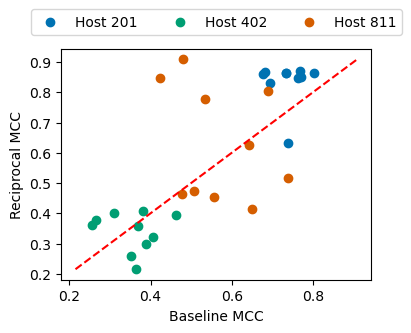

In [22]:
# Plotting Baseline vs Reciprocal MCC for each host using the 'test' mode scores
mode_plot = "test"

fig, ax = plt.subplots(figsize=(4,3))
# Use a colorblind-friendly palette for thesis-quality plots
host_colors = {201: '#0072B2', 811: '#D55E00', 402: '#009E73'}  # Blue, vermillion, and green from Color Universal Design

for h in hosts:
    baseline_mcc = all_runs[h]['baseline'][mode_plot]['mccs']
    reciprocal_mcc = all_runs[h]['reciprocal'][mode_plot]['mccs']
    ax.scatter(baseline_mcc, reciprocal_mcc, color=host_colors[h], label=f"Host {h}")

# Determine limits for the equilibrium line
all_vals = []
for h in hosts:
    all_vals.extend(all_runs[h]['baseline'][mode_plot]['mccs'])
    all_vals.extend(all_runs[h]['reciprocal'][mode_plot]['mccs'])
lims = [min(all_vals), max(all_vals)]
ax.plot(lims, lims, 'r--')

ax.set_xlabel("Baseline MCC")
ax.set_ylabel("Reciprocal MCC")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(hosts))
fig.savefig("plots/baseline_vs_reciprocal_mcc.pdf", bbox_inches='tight')
plt.show()
plt.close(fig)